In [1]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [3]:
df_alpha = wr.s3.read_parquet(s3_collection_path + "seekingAlpha.seekingAlphaBulkMetrics/2023-09-28.parquet", boto3_session=session)
df_guru = wr.s3.read_parquet(s3_collection_path + "gurufocus/2023-09-28.parquet", boto3_session=session)

In [4]:
df_alpha.shape, df_guru.shape

((1570, 265), (1570, 70))

In [5]:
df_alpha.head(2)

,ticker,altman_z_score,analysts_down,analysts_down_percent,analysts_down_percent_avg_5y,analysts_up,analysts_up_percent,analysts_up_percent_avg_5y,assets_turnover,assets_turnover_avg_5y,...,total_debt,total_revenue,working_cap_change,working_cap_change_avg_5y,yld_on_cost_1y,yld_on_cost_1y_avg_5y,yld_on_cost_3y,yld_on_cost_3y_avg_5y,yld_on_cost_5y,yld_on_cost_5y_avg_5y
0,A,6.153144,15.0,100.0,12.759212,0.0,0.0,87.240790,0.661089,0.601508,...,2.967000e+09,6.994000e+09,26.9574,-0.632706,0.727736,0.800686,0.905927,1.203941,1.250000,1.473696
1,AA,1.401235,7.0,100.0,60.404625,0.0,0.0,39.595375,0.728491,0.757975,...,1.834000e+09,1.086800e+10,-21.0507,20.247938,1.152738,NaN,3.463203,NaN,0.987654,NaN


In [6]:
df_guru.head(2)

,symbol,growth_rank,3-Year_Revenue_Growth_Rate,3-Year_EBITDA_Growth_Rate,3-Year_EPS_without_NRI_Growth_Rate,3-Year_FCF_Growth_Rate,3-Year_Book_Growth_Rate,Future_3-5Y_EPS_without_NRI_Growth_Rate,Future_3-5Y_Total_Revenue_Growth_Rate,profitability_rank,...,Price-to-Graham-Number,Earnings_Yield__Greenblatt__%,Forward_Rate_of_Return__Yacktman__%,sector,area,Price-to-DCF__Earnings_Based_,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO
0,A,0.8,12.0,17.9,7.4,7.8,5.4,7.46,3.18,0.9,...,6.31,4.35,17.97,Healthcare,Medical Diagnostics & Research,NaN,NaN,NaN,NaN,NaN
1,AA,0.4,6.8,54.4,51.8,4.4,9.0,NaN,-0.36,0.5,...,NaN,-20.83,-1.42,Basic Materials,Metals & Mining,NaN,NaN,NaN,NaN,NaN


In [7]:
df_alpha = df_alpha.set_index("ticker")
df_guru = df_guru.set_index("symbol")

In [10]:
joined_df = pd.concat([df_alpha, df_guru], axis = 1)

In [11]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    return fig

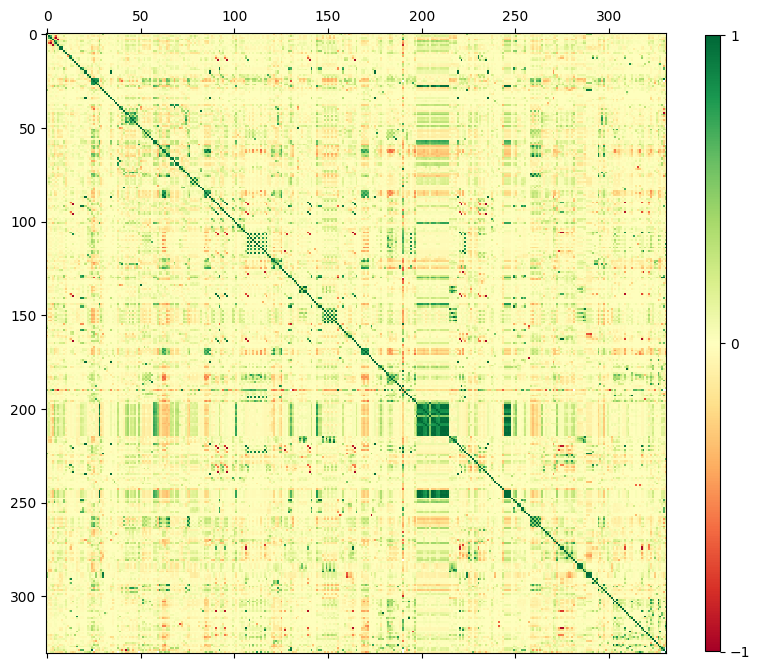

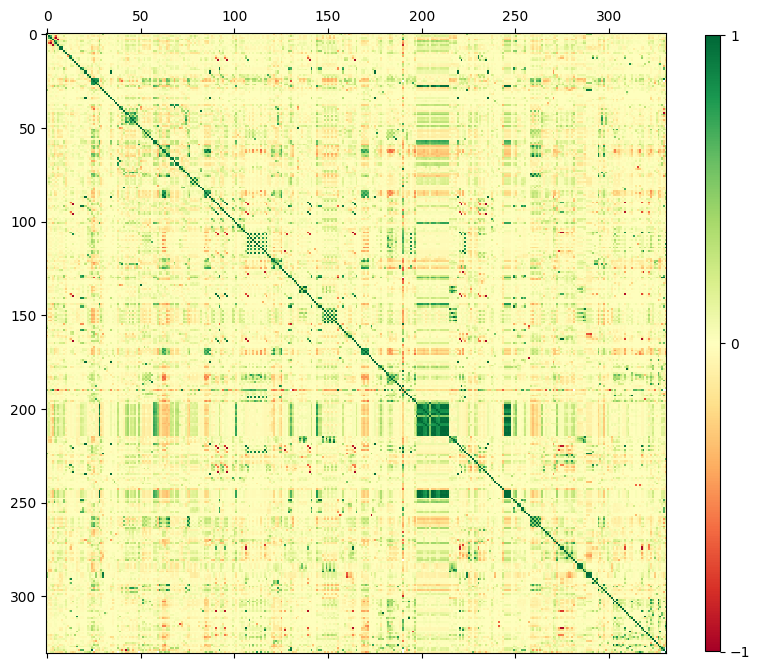

In [14]:
float_df = joined_df.select_dtypes(float)
int_df = joined_df.select_dtypes(int)
plot_corr(float_df)

In [15]:
# Source: https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb

import scipy
import numpy as np
import scipy.cluster.hierarchy as sch

float_df = float_df.fillna(0.)

X = float_df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [float_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
float_df = float_df.reindex(columns = columns)


In [18]:
float_df.shape

(1570, 331)

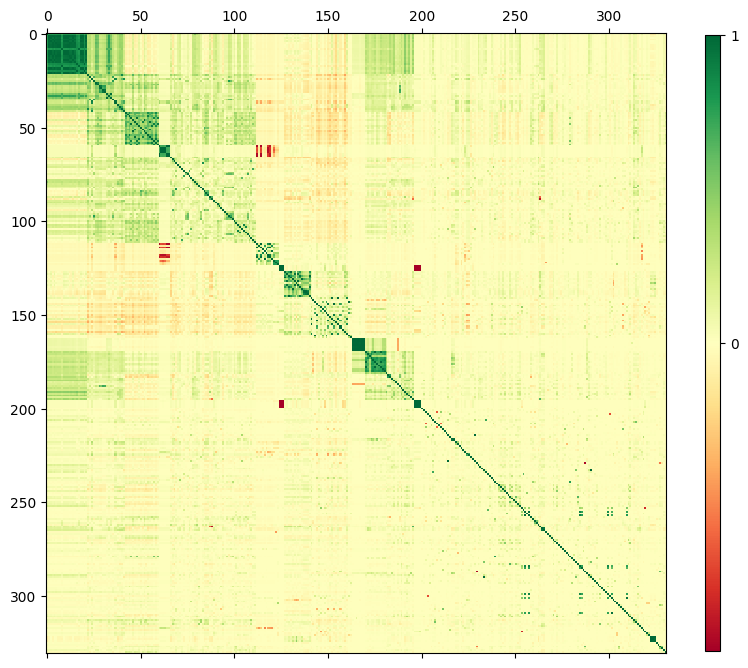

In [17]:
plot_corr(float_df)
pass

### Feature Neutralization (Residual)

In [20]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [22]:
new_df = pd.DataFrame()
for c in tqdm(float_df.columns):
	y = float_df[c].values
	X = float_df.drop(c, axis = 1)
	linreg = LinearRegression()
	linreg.fit(X, y)
	y_pred = linreg.predict(X)
	new_df[c] = y - y_pred

 30%|███       | 100/331 [00:34<01:26,  2.67it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_36119/363559078.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c] = y - y_pred
 31%|███       | 101/331 [00:34<01:22,  2.78it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_36119/363559078.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[c] = y - y_pred
 31%|███       | 102/331 [00:35<01:24,  2.72it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_36119/363559078.py:8: Perfor

In [23]:
new_df.head()

,log_of_unadjusted_stock_price,sma_200d,sma_10d,price_close_adj_ytd,price_close_1w,price_low_52w,price_close_adj_6m,price_close_6m,price_close_adj_5y,close,...,int_cover_avg_5y,last_price_vs_sma_100d,last_price_vs_sma_200d,last_price_vs_sma_50d,levered_free_cash_flow_yoy,levered_free_cash_flow_yoy_avg_5y,net_inc_per_employee,net_inc_per_employee_avg_5y,impliedmarketcap,Price-to-FFO
0,0.063705,1.060518,-0.057753,0.267083,-0.008568,1.965087,0.021914,-0.026785,-0.780539,0.914236,...,-1572.593677,-0.550084,1.041761,0.655113,592.783185,-2753.368703,1.057500e+05,4.918414e+05,-2.123314e+08,-1.635112
1,0.270802,0.401002,-0.713226,0.059208,0.000384,-2.496642,-0.087988,0.087205,0.162660,0.826666,...,-3985.308351,0.755484,-2.220504,-0.573334,1719.500189,-2085.922419,-5.083659e+05,3.430403e+05,2.626233e+09,-3.332006
2,-0.378963,-0.172047,0.041533,-0.046588,-0.007983,1.003530,-0.013241,0.014769,0.320864,-0.219022,...,-588.280329,-0.513827,0.145673,0.799587,904.422538,-1103.644362,1.059282e+06,-8.377927e+05,-1.219865e+09,4.921363
3,-0.448955,0.274933,-0.048035,0.570534,0.027397,-9.562371,-0.050034,0.046411,0.596288,-0.147162,...,405.098107,-3.708228,8.981835,3.653588,2417.297802,7340.721424,1.512726e+06,1.167170e+05,-1.443190e+09,0.068269
4,0.639099,2.013416,-1.961343,0.259446,0.014232,1.699130,0.052111,-0.056888,-0.196200,2.561612,...,700.997435,-1.540826,2.599370,2.198937,-871.090770,-2530.587645,-7.515172e+05,1.502208e+06,1.834480e+08,-4.402405


In [24]:
new_df.index = float_df.index
new_df.head()

,log_of_unadjusted_stock_price,sma_200d,sma_10d,price_close_adj_ytd,price_close_1w,price_low_52w,price_close_adj_6m,price_close_6m,price_close_adj_5y,close,...,int_cover_avg_5y,last_price_vs_sma_100d,last_price_vs_sma_200d,last_price_vs_sma_50d,levered_free_cash_flow_yoy,levered_free_cash_flow_yoy_avg_5y,net_inc_per_employee,net_inc_per_employee_avg_5y,impliedmarketcap,Price-to-FFO
A,0.063705,1.060518,-0.057753,0.267083,-0.008568,1.965087,0.021914,-0.026785,-0.780539,0.914236,...,-1572.593677,-0.550084,1.041761,0.655113,592.783185,-2753.368703,1.057500e+05,4.918414e+05,-2.123314e+08,-1.635112
AA,0.270802,0.401002,-0.713226,0.059208,0.000384,-2.496642,-0.087988,0.087205,0.162660,0.826666,...,-3985.308351,0.755484,-2.220504,-0.573334,1719.500189,-2085.922419,-5.083659e+05,3.430403e+05,2.626233e+09,-3.332006
AAL,-0.378963,-0.172047,0.041533,-0.046588,-0.007983,1.003530,-0.013241,0.014769,0.320864,-0.219022,...,-588.280329,-0.513827,0.145673,0.799587,904.422538,-1103.644362,1.059282e+06,-8.377927e+05,-1.219865e+09,4.921363
AAP,-0.448955,0.274933,-0.048035,0.570534,0.027397,-9.562371,-0.050034,0.046411,0.596288,-0.147162,...,405.098107,-3.708228,8.981835,3.653588,2417.297802,7340.721424,1.512726e+06,1.167170e+05,-1.443190e+09,0.068269
AAPL,0.639099,2.013416,-1.961343,0.259446,0.014232,1.699130,0.052111,-0.056888,-0.196200,2.561612,...,700.997435,-1.540826,2.599370,2.198937,-871.090770,-2530.587645,-7.515172e+05,1.502208e+06,1.834480e+08,-4.402405


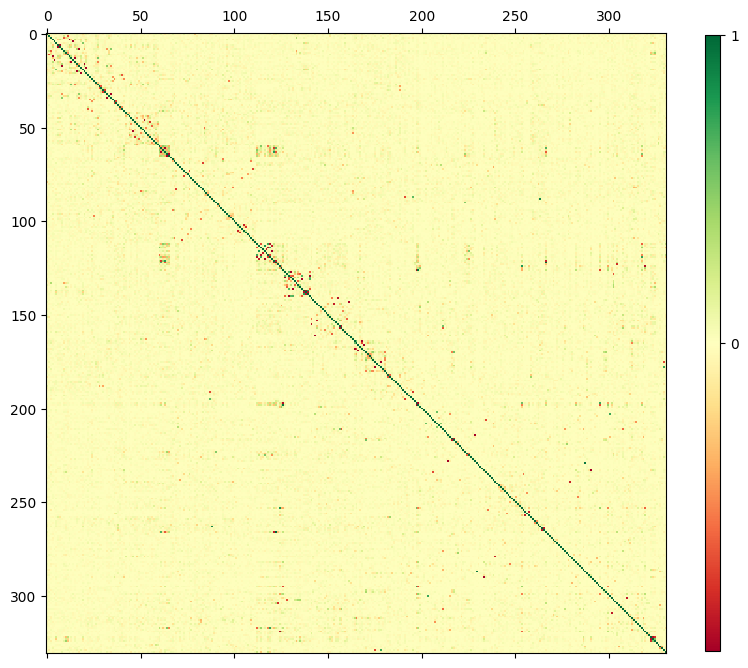

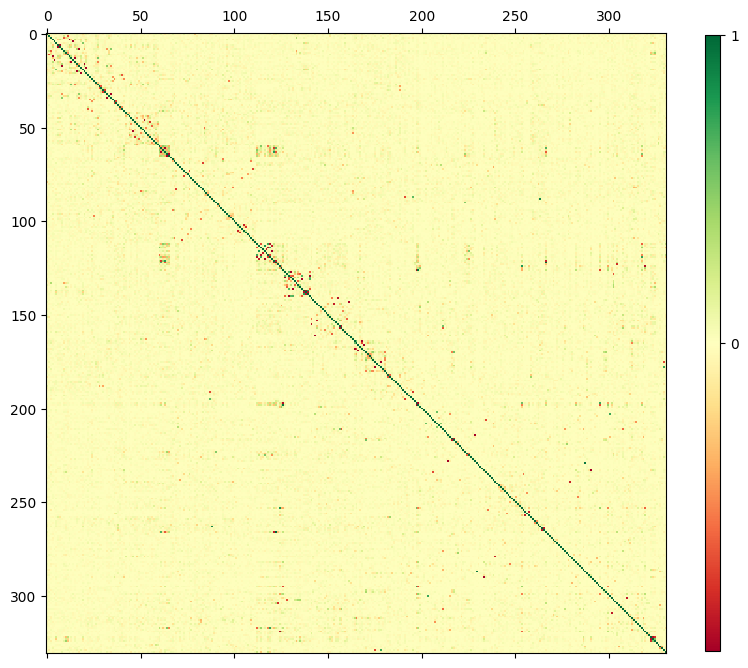

In [25]:
plot_corr(new_df)

In [26]:
new_df.describe()

,log_of_unadjusted_stock_price,sma_200d,sma_10d,price_close_adj_ytd,price_close_1w,price_low_52w,price_close_adj_6m,price_close_6m,price_close_adj_5y,close,...,int_cover_avg_5y,last_price_vs_sma_100d,last_price_vs_sma_200d,last_price_vs_sma_50d,levered_free_cash_flow_yoy,levered_free_cash_flow_yoy_avg_5y,net_inc_per_employee,net_inc_per_employee_avg_5y,impliedmarketcap,Price-to-FFO
count,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,...,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03,1.570000e+03
mean,-4.664917e-15,-3.539136e-15,-5.255301e-14,2.135249e-14,-3.998451e-14,-1.248564e-13,-4.232708e-15,-1.861780e-15,2.164214e-14,8.931567e-14,...,3.632418e-11,8.661154e-15,9.436189e-15,9.298493e-14,3.967019e-12,3.327105e-10,-8.121607e-08,1.057318e-08,2.526933e-07,3.210748e-13
std,4.073290e-01,9.700948e-01,6.219585e-01,1.736513e-01,5.801786e-02,5.070487e+00,1.146794e-01,1.150892e-01,1.184739e+00,1.373144e+00,...,5.295100e+03,1.683471e+00,4.977016e+00,1.784388e+00,4.662585e+03,1.069767e+04,2.155562e+06,2.254766e+06,3.304427e+09,1.485852e+01
min,-2.214248e+00,-1.075024e+01,-3.966878e+00,-1.930336e+00,-2.472981e-01,-4.329679e+01,-8.607587e-01,-1.850247e+00,-1.130461e+01,-9.052255e+00,...,-5.284603e+04,-1.977662e+01,-2.906877e+01,-1.996995e+01,-1.700451e+05,-3.823837e+05,-2.122638e+07,-7.698240e+07,-1.077085e+10,-5.869110e+01
25%,-2.208106e-01,-3.781299e-01,-2.533976e-01,-6.209803e-02,-1.420497e-02,-2.134742e+00,-3.803133e-02,-3.522819e-02,-4.633184e-01,-5.579022e-01,...,-1.067102e+03,-8.133375e-01,-2.389629e+00,-8.398018e-01,-7.763157e+02,-1.872915e+03,-5.870260e+05,-4.737880e+05,-1.049602e+09,-3.841129e+00
50%,1.538198e-02,-1.286401e-02,1.026787e-02,-2.117564e-03,-2.091046e-03,-8.421235e-03,-2.317181e-03,2.147600e-03,1.349953e-03,-1.157269e-02,...,-7.061135e+00,-2.088219e-03,-1.121802e-02,-4.140705e-03,3.481784e+01,1.089072e+02,1.263219e+04,2.145074e+03,-9.222200e+07,-9.934470e-02
75%,2.403679e-01,3.790641e-01,2.564543e-01,5.282154e-02,8.192311e-03,2.197488e+00,3.467764e-02,3.651946e-02,5.023067e-01,5.545575e-01,...,8.984156e+02,8.643269e-01,2.209910e+00,7.995487e-01,8.777600e+02,2.111540e+03,5.151583e+05,5.217371e+05,7.756233e+08,3.389238e+00
max,1.678824e+00,9.473633e+00,5.685080e+00,1.510535e+00,1.235169e+00,3.534589e+01,1.847662e+00,8.668352e-01,1.004690e+01,9.711197e+00,...,1.862812e+05,8.669076e+00,6.149063e+01,1.689835e+01,2.781213e+04,3.441956e+04,3.843336e+07,1.519306e+07,8.350048e+10,4.445378e+02


In [28]:
new_df.describe().loc["mean"].abs().sort_values()

growth_rank                                1.352068e-16
dividends_estimate_fy2_analyst_up          1.538755e-16
price_close_adj_1w                         2.800308e-16
beta24                                     3.066196e-16
profitability_rank                         4.146718e-16
                                               ...     
marketcap                                  4.140040e-05
cash_from_operations_as_reported           4.634250e-05
tev                                        8.546866e-05
gross_profit                               8.728125e-05
cash_from_operations_as_reported_avg_5y    1.488024e-04
Name: mean, Length: 331, dtype: float64